In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/interbank20/sample_submission.csv
/kaggle/input/interbank20/y_train.csv
/kaggle/input/interbank20/sunat_test.csv
/kaggle/input/interbank20/rcc_test.csv
/kaggle/input/interbank20/se_test.csv
/kaggle/input/interbank20/sunat_train.csv
/kaggle/input/interbank20/se_train.csv
/kaggle/input/interbank20/censo_test.csv
/kaggle/input/interbank20/productos.csv
/kaggle/input/interbank20/censo_train.csv
/kaggle/input/interbank20/rcc_train.csv


## Cargar todas las bases

In [3]:
# sunat_train = pd.read_csv('/kaggle/input/interbank20/sunat_train.csv')
rcc_train = pd.read_csv("/kaggle/input/interbank20/rcc_train.csv")
# se_train = pd.read_csv("/kaggle/input/interbank20/se_train.csv", index_col="key_value")
# censo_train = pd.read_csv("/kaggle/input/interbank20/censo_train.csv", index_col="key_value")
y_train = pd.read_csv("/kaggle/input/interbank20/y_train.csv", index_col="key_value")

# sunat_test = pd.read_csv('/kaggle/input/interbank20/sunat_test.csv')
rcc_test = pd.read_csv("/kaggle/input/interbank20/rcc_test.csv")
# se_test = pd.read_csv("/kaggle/input/interbank20/se_test.csv", index_col="key_value")
# censo_test = pd.read_csv("/kaggle/input/interbank20/censo_test.csv", index_col="key_value")
# sample_submision = pd.read_csv('/kaggle/input/interbank20/sample_submission.csv',index_col="key_value")

In [4]:
### se puede observar que en el rcc_train aquellos clientes que tienen un solo registro, es porque se refiere al ultimo
### periodo de la data de train que es del febrero del 2018, cuyo RIESGO_DIRECTO es 1 y COD_CLASIFICACION_DEUDOR es 0 
### su condicion (días de atraso) es 0 siendo estos cerca de 623 clientes. Pero OJO el 9% de los nuevos clientes tienen un target igual a 1

### el target de la data train representa el score crediticio al febrero del 2018 
### por lo que se sobre-entiende que lo que se quiere predecir es el score crediticio al febrero del 2019

### La data train abarca desde 201703 hasta 201802
### La data test comprende desde 201803 hasta 201902
### Los primeros registros de los clientes tienen un RIESGO DIRECTO de 1 ***

### La distribucion del target general es de 16% para 1 y 84% para los 0
### A mayor COD_CLASIFICACION_DEUDOR y codmes mes cercano, el target se aproxima a 1. Ejm COD_CLASIFICACION_DEUDOR=5 y codmes=201802
### el target esta representado por el 97% de 1 y 3% de cero 

In [5]:
### condicion, saldo   ..... son variables cuantitativas
### tipo_credito en train no tiene la clase de 7 como en el test, pero este tiene solo 1 valor (8 clases) ### Frecuencia 11
### cod_instit_financiera , 12 clases más se encuentran en el train que en el test (mas de 100 clases) ### Frecuencia 34 ----
### PRODUCTO, el train tiene la clase 255 y el test no (42 clases) ### Frecuencia 1  ----
### RIESGO_DIRECTO es lo mismo , es lo mismo en el test y en el train (5 clases) ### Frecuencia -1
### COD_CLASIFICACION_DEUDOR , es lo mismo en el test y en el train (6 clases) ### Frecuencia 0
### en el rcc_test, faltan valores en la columma de cod_instit_financiera y producto

In [6]:
bins = [-1, 0, 10, 20, 30, 60, 90, 180, 360, 720, float("inf")]
rcc_train["condicion"] = pd.cut(rcc_train.condicion, bins, labels = range(0,10))
rcc_test["condicion"] = pd.cut(rcc_test.condicion, bins, labels = range(0,10))

In [7]:
rcc_test['cod_instit_financiera'] = rcc_test['cod_instit_financiera'].fillna(34)
rcc_test['PRODUCTO'] = rcc_test['PRODUCTO'].fillna(1)

In [8]:
rcc_train = rcc_train.astype({'condicion':'int32',
                  'tipo_credito':'int32',
                  'cod_instit_financiera':'int32',
                  'PRODUCTO':'int32',
                  'RIESGO_DIRECTO':'int32',
                  'COD_CLASIFICACION_DEUDOR':'int32'})
rcc_test = rcc_test.astype({'condicion':'int32',
                  'tipo_credito':'int32',
                  'cod_instit_financiera':'int32',
                  'PRODUCTO':'int32',
                  'RIESGO_DIRECTO':'int32',
                  'COD_CLASIFICACION_DEUDOR':'int32'})

In [9]:
from tqdm.notebook import tqdm 
list_rcc_train_agg = []
for n,i in enumerate(tqdm(sorted(set(rcc_train.codmes),reverse=True))):
    if i in [201802,201712,201709,201703]:
        for c in ['tipo_credito','cod_instit_financiera','PRODUCTO','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR','condicion']:
            rcc_train_agg = rcc_train[rcc_train.codmes>=i].groupby(['key_value', c]).saldo.sum().unstack(level = 1, fill_value=0)
            rcc_train_agg.columns = [f'{rcc_train_agg.columns.name}_{c}_ult{n+1}meses' for c in rcc_train_agg.columns]
            list_rcc_train_agg.append(rcc_train_agg)
        gc.collect()

In [10]:
rcc_train_ = pd.concat(list_rcc_train_agg, axis=1)
del rcc_train, list_rcc_train_agg

In [11]:
from tqdm.notebook import tqdm 
list_rcc_test_agg = []
for n,i in enumerate(tqdm(sorted(set(rcc_test.codmes),reverse=True))):
    if i in [201902,201812,201809,201803]:
        for c in ['tipo_credito','cod_instit_financiera','PRODUCTO','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR','condicion']:
            rcc_test_agg = rcc_test[rcc_test.codmes>=i].groupby(['key_value', c]).saldo.sum().unstack(level = 1, fill_value=0)
            rcc_test_agg.columns = [f'{rcc_test_agg.columns.name}_{c}_ult{n+1}meses' for c in rcc_test_agg.columns]
            list_rcc_test_agg.append(rcc_test_agg)
        gc.collect()

In [12]:
rcc_test_ = pd.concat(list_rcc_test_agg, axis=1)
del rcc_test, list_rcc_test_agg

In [13]:
se_train = pd.read_csv("/kaggle/input/interbank20/se_train.csv", index_col="key_value")
censo_train = pd.read_csv("/kaggle/input/interbank20/censo_train.csv", index_col="key_value")
se_test = pd.read_csv("/kaggle/input/interbank20/se_test.csv", index_col="key_value")
censo_test = pd.read_csv("/kaggle/input/interbank20/censo_test.csv", index_col="key_value")
gc.collect()

4

In [14]:
train = rcc_train_.join(censo_train).join(se_train)
test = rcc_test_.join(censo_test).join(se_test)

In [15]:
train.shape, test.shape

((358487, 966), (396666, 918))

In [16]:
del se_train, se_test, censo_train, censo_test
gc.collect()

40

In [17]:
keep_cols = list(set(train.columns).intersection(set(test.columns)))
train = train[keep_cols].copy()
test = test[keep_cols].copy()
len(set(train.columns) - set(test.columns)) , len(set(test.columns) - set(train.columns))

(0, 0)

In [18]:
import re
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_-]+', '', x))
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_-]+', '', x))

In [19]:
#Función para obtener variables con alta correlación
def get_correlated(data, cut=0.85):
    correlated_features = set()
    correlation_matrix = data.corr()
    
    for i in range(len(correlation_matrix .columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > cut:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
            
    return correlated_features

In [20]:
train.shape

(358487, 911)

In [21]:
correlated=get_correlated(train,cut=0.9)
train=train.drop(columns=correlated)
test= test.drop(columns=correlated)

In [22]:
train.shape

(358487, 384)

In [23]:

# !pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]
    
    learner = CatBoostClassifier(n_estimators=1000, depth = 6, eval_metric = 'AUC' )
    learner.fit(Xt, yt,  early_stopping_rounds=10,
                eval_set=[(Xt, yt), (Xv, yv)], verbose=50)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
          
test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)

print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))

********** 0 **********
Learning rate set to 0.128212
0:	test: 0.7536250	test1: 0.7606110	best: 0.7606110 (0)	total: 410ms	remaining: 6m 49s
50:	test: 0.8407739	test1: 0.8403098	best: 0.8403098 (50)	total: 20.6s	remaining: 6m 23s
100:	test: 0.8514598	test1: 0.8498040	best: 0.8498040 (100)	total: 41.1s	remaining: 6m 5s
150:	test: 0.8586246	test1: 0.8550781	best: 0.8550781 (150)	total: 1m	remaining: 5m 41s
200:	test: 0.8629105	test1: 0.8577433	best: 0.8577433 (200)	total: 1m 19s	remaining: 5m 14s
250:	test: 0.8666198	test1: 0.8594593	best: 0.8594593 (250)	total: 1m 38s	remaining: 4m 53s
300:	test: 0.8690515	test1: 0.8603899	best: 0.8603899 (300)	total: 1m 55s	remaining: 4m 28s
350:	test: 0.8712705	test1: 0.8610930	best: 0.8610939 (349)	total: 2m 12s	remaining: 4m 4s
400:	test: 0.8736445	test1: 0.8619265	best: 0.8619265 (400)	total: 2m 30s	remaining: 3m 45s
450:	test: 0.8757096	test1: 0.8624102	best: 0.8624158 (440)	total: 2m 47s	remaining: 3m 24s
Stopped by overfitting detector  (10 iter

In [43]:
fi.sort_values(ascending=False).head(50)#.plot.bar(figsize=(15,10))

COD_CLASIFICACION_DEUDOR_5_ult6meses     0.175711
PRODUCTO_1_ult1meses                     0.060174
PRODUCTO_3_ult3meses                     0.026772
RIESGO_DIRECTO_2_ult1meses               0.026058
PRODUCTO_0_ult1meses                     0.024697
cod_instit_financiera_32_ult3meses       0.020093
COD_CLASIFICACION_DEUDOR_1_ult1meses     0.019985
RIESGO_DIRECTO_1_ult12meses              0.019457
PRODUCTO_8_ult6meses                     0.016699
PRODUCTO_6_ult1meses                     0.016565
tipo_credito_12_ult1meses                0.014632
PRODUCTO_2_ult1meses                     0.014455
tipo_credito_11_ult6meses                0.014019
cod_instit_financiera_33_ult1meses       0.013617
edad                                     0.012796
PRODUCTO_6_ult12meses                    0.012750
PRODUCTO_4_ult1meses                     0.012177
cod_instit_financiera_55_ult6meses       0.011756
cod_instit_financiera_61_ult1meses       0.010993
tip_lvledu                               0.010935


In [26]:
test_probs.name = "target"
test_probs.to_csv("test4.csv")

<a href="test4.csv"> Download csv </a>

In [29]:
learner_ = CatBoostClassifier(n_estimators=1000, depth = 6, eval_metric = 'AUC' )
learner_.fit(train, y_train,  early_stopping_rounds=10)

Learning rate set to 0.126968
0:	total: 437ms	remaining: 7m 16s
1:	total: 907ms	remaining: 7m 32s
2:	total: 1.29s	remaining: 7m 10s
3:	total: 1.67s	remaining: 6m 56s
4:	total: 2.05s	remaining: 6m 48s
5:	total: 2.37s	remaining: 6m 32s
6:	total: 2.76s	remaining: 6m 32s
7:	total: 3.24s	remaining: 6m 42s
8:	total: 3.57s	remaining: 6m 32s
9:	total: 4.03s	remaining: 6m 38s
10:	total: 4.35s	remaining: 6m 31s
11:	total: 4.96s	remaining: 6m 47s
12:	total: 5.35s	remaining: 6m 46s
13:	total: 5.67s	remaining: 6m 39s
14:	total: 6.07s	remaining: 6m 38s
15:	total: 6.62s	remaining: 6m 46s
16:	total: 7.13s	remaining: 6m 52s
17:	total: 7.48s	remaining: 6m 47s
18:	total: 8.23s	remaining: 7m 5s
19:	total: 8.73s	remaining: 7m 7s
20:	total: 9.14s	remaining: 7m 6s
21:	total: 9.52s	remaining: 7m 3s
22:	total: 9.95s	remaining: 7m 2s
23:	total: 10.3s	remaining: 6m 59s
24:	total: 10.9s	remaining: 7m 5s
25:	total: 11.4s	remaining: 7m 8s
26:	total: 12.1s	remaining: 7m 16s
27:	total: 12.5s	remaining: 7m 15s
28:	tot

In [42]:
fi_ = pd.Series(learner_.feature_importances_ / learner_.feature_importances_.sum(), index=train.columns)
fi_.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_ult6meses     0.152520
PRODUCTO_1_ult1meses                     0.061754
profe_9                                  0.033261
PRODUCTO_3_ult3meses                     0.024211
profe_6                                  0.022972
RIESGO_DIRECTO_2_ult1meses               0.021943
agundia6                                 0.021889
RIESGO_DIRECTO_1_ult12meses              0.021089
tipo_credito_12_ult1meses                0.020374
cod_instit_financiera_32_ult3meses       0.020185
PRODUCTO_0_ult1meses                     0.019412
COD_CLASIFICACION_DEUDOR_1_ult1meses     0.018415
tipo_credito_11_ult6meses                0.016425
hig5                                     0.014622
PRODUCTO_8_ult6meses                     0.014373
PRODUCTO_2_ult1meses                     0.013457
edad                                     0.013457
PRODUCTO_6_ult12meses                    0.012725
PRODUCTO_6_ult1meses                     0.011982
COD_CLASIFICACION_DEUDOR_3_ult12meses    0.011699


In [35]:
test_probs_ = pd.Series(learner_.predict_proba(test)[:, -1], index=test.index, name="target")

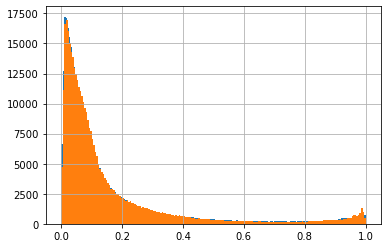

In [39]:
test_probs_.hist(bins = 200)
test_probs.hist(bins = 200)

In [45]:
test_probs_.name = "target"
test_probs_.to_csv("test4_v2.csv")

<a href = 'test4_v2.csv'> Download csv</a>